In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer as qv
import boulderopal as bo

#bo.cloud.set_verbosity('QUIET')
plt.style.use(qv.get_qctrl_style())

controls_for_plots = lambda opt: {
    '$\\Delta$': opt['output']['delta'],
    '$\\Omega$': opt['output']['omega'],
    '$\\Phi$': opt['output']['phi']
}

In [3]:
# Set parameters.
omega_max = 5 * 2 * np.pi * 1e6 # rad/s
delta_max = omega_max
tau = 0.4 * 1e-6 # s

# Define the control.
segment_count = 2
sample_times = np.linspace(0, tau, 200)

# Define basis.
basis_labels = ['0', '1', 'r', '11', 'W']

# Components for the drive operator.
drive_operator = np.zeros((5, 5))
drive_operator[1, 2] = 1
drive_operator[3, 4] = np.sqrt(2)

# Components for the detuning operator.
detuning_operator = np.diag([0, 0, -1, 0, -1])

# Components for the CZ operator.
cz_0 = np.diag([1, 0, 0, 0, 0])
cz_1 = np.diag([0, 1, 0, 0, 0])
cz_11 = np.diag([0, 0, 0, 1, 0])

In [6]:
def optimize_LP_gate(omega_max, delta_max, tau, segment_count):
    graph = bo.Graph()
    sample_times = np.linspace(0, tau, 200)
    # Real piece-wise constant signal representing the detuning.
    delta = (
        graph.real_optimizable_pwc_signal(
            segment_count = 1, 
            duration = tau, 
            minimum = 0,
            maximum = delta_max,
            name = 'delta'
        )
    )

    # Real piece-wise constant signal representing the Rabi amplitude.
    omega = (
        graph.real_optimizable_pwc_signal(
            segment_count = 1, 
            duration = tau, 
            minimum = 0,
            maximum = omega_max,
            name = 'omega'
        )
    )

    # Real piece-wise constant signal representing the Rabi phase.
    phi = (
        graph.real_optimizable_pwc_signal(
            segment_count = segment_count, 
            duration = tau, 
            minimum = 0,
            maximum = 2 * np.pi, 
            name = 'phi'
        )
    )

    # Real scalar signal representing the single qubit phase.
    psi = (
        graph.optimizable_scalar(
            lower_bound = 0,
            upper_bound = 2 * np.pi, 
            name = 'psi'
        )
    )
    # if amplitude_error == True:
    #     scan_point_count = 0.01
    #     amplitude_error_values = np.arange(0,0.10,scan_point_count)
    #     amp_noise_signals = []
    #     for i in range(len(amplitude_error_values)):
    #         amp_noise_signals.append(
    #             graph.constant_pwc(
    #                 constant=amplitude_error_values[i][None, :, None],
    #                 duration=tau,
    #                 batch_dimension_count= 2))
    
    
        
    # Define the Hamiltonian.
    hamiltonian = (
    graph.hermitian_part(omega * graph.exp(1j * phi) * drive_operator) + 
    delta * detuning_operator
    )

        # Define the target operator.
    target = (
        graph.target(
            operator = (
                cz_0 +
                graph.exp(1j * psi) * cz_1 + 
                graph.exp(1j * (2 * psi + np.pi)) * cz_11
            )
        )
    )

    # Unitary time evolution.
    unitary = (
        graph.time_evolution_operators_pwc(
            hamiltonian = hamiltonian, 
            sample_times = sample_times, 
            name = 'unitary'
        )
    )

    # Infidelity.
    infidelity = (
        graph.infidelity_pwc(
            hamiltonian = hamiltonian,
            target = target,
            name = 'infidelity'
        )
    )

    # Cost function.
    cost_function = (
        graph.sum(
            infidelity
        )
    )
    cost_function.name = 'cost_function'
    
    result = (
    bo.run_optimization(
        graph = graph,
        cost_node_name = 'cost_function',
        output_node_names = [
            'omega', 
            'delta', 
            'phi', 
            'psi', 
            'unitary',
            'infidelity'
        ],
    )
)
    return result

In [7]:
result = optimize_LP_gate(omega_max, delta_max, tau, 2)

print("Gate infidelity is", f"{result['output']['infidelity']['value']:.3e}")

Your task (action_id="1988840") is queued.
Your task (action_id="1988840") has started.
Your task (action_id="1988840") has completed.
Gate infidelity is 1.644e-11


In [8]:
eta = result['output']['delta']['values'][0] / result['output']['omega']['values'][0]
xi = np.abs(result['output']['phi']['values'][0] - result['output']['phi']['values'][1])
omegatau = result['output']['omega']['values'][0] * tau / 2

print(f"Infidelity: {result['output']['infidelity']['value']:.3e}")
print(f"Gate time: {omegatau}")
print(f"Ratio of detuning and Rabi frequncy: {eta}")
print(f"Phase jump: {xi}")
print(f"Equivalent phase jump: {2 * np.pi - xi}")
print(f"Single qubit phase: {result['output']['psi']['value']}")

Infidelity: 1.644e-11
Gate time: 4.292673483637149
Ratio of detuning and Rabi frequncy: 0.37737220831287677
Phase jump: 2.3807573586439297
Equivalent phase jump: 3.9024279485356566
Single qubit phase: 2.3807633573111344


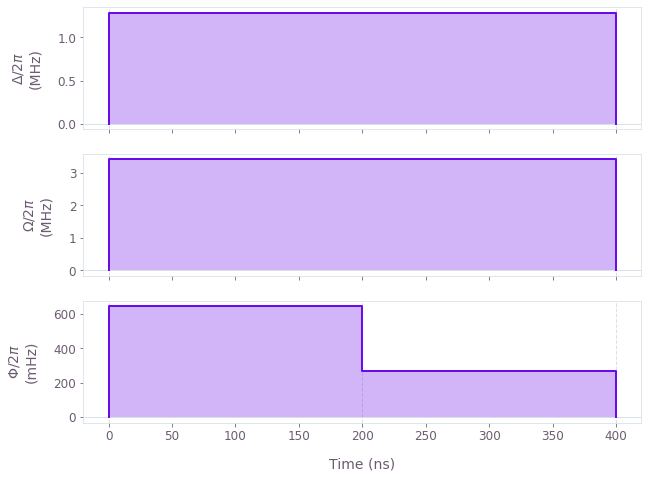

In [9]:
qv.plot_controls(controls_for_plots(result))

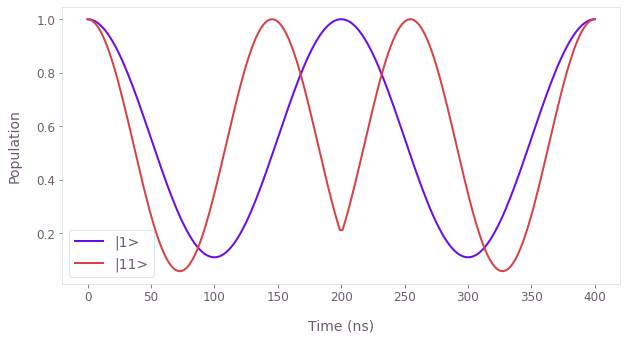

In [130]:
u = result['output']['unitary']['value']

psi1 = np.array([0,1,0,0,0])
out1 = np.abs(np.transpose(psi1) @ u @ psi1)**2
psi11 = np.array([0,0,0,1,0])
out11 = np.abs(np.transpose(psi11) @ u @ psi11)**2

plt.plot(1e9 * sample_times, out1)
plt.plot(1e9 * sample_times, out11)
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.legend(['|1>', '|11>'])

## Attempt #1
#### As done in: https://docs.q-ctrl.com/boulder-opal/application-notes/designing-robust-rydberg-blockade-two-qubit-gates-in-cold-atoms?organization=atom-computing

#### Amplitude Noise (constant amplitude offset)

Amplitude and detuning errors are treated as quasi-static coherent error terms in the Hamiltonian during the gate, with the transformations:

\begin{align*}
\Omega &\rightarrow \Omega +\delta \Omega \\
\Delta &\rightarrow \Delta + \delta\Delta 

\end{align*}

I believe this is supposed to call the results from the LP gate above and add an amplitude error to the hamiltonian (here I've defined it aas a constant offset, but could be changed ofc)

In [115]:
#define error range for scan
scan_point_count = 0.01
amplitude_error_values = np.arange(0,0.10,scan_point_count)

#define list of control params
control_list = [ result.values()
]


def noise_sim(controls_result, amplitude_error_values
):
    graph = bo.Graph()
    
    #get values 
    Omega = graph.pwc(**controls_result["output"]["omega"])
    Delta = graph.pwc(**controls_result["output"]["delta"])
    Phi = graph.pwc(**controls_result["output"]["phi"])
    Psi = graph.scalar(**controls_result["output"]["psi"])

    amplitude_error = graph.constant_pwc(
        constant=amplitude_error_values,
        duration=tau,
        batch_dimension_count=1,
    )
    #add amplitude noise to the hamiltonian
    hamiltonian = (
        graph.hermitian_part(
            ((Omega + amplitude_error) * graph.exp(1j * Phi) * drive_operator) 
            + Delta * detuning_operator
        )
    )

    target = (
        graph.target(
            operator=(
                cz_0
                + graph.exp(1j * Psi) * cz_1
                + graph.exp(1j * (2 * Psi + np.pi)) * cz_11
            )
        )
    )

    infidelity = graph.infidelity_pwc(
        hamiltonian=hamiltonian, target=target, name="infidelity"
    )
    
    result = bo.execute_graph(graph, "infidelity")


In [116]:
# Run the amplitude error scans for pulse.

with bo.cloud.group_requests():
    infidelity_scan = [
        noise_sim(control, amplitude_error_values)
        for control in control_list
    ]

    

TypeError: 'dict_values' object is not subscriptable

In [117]:
#characterize susceptibility to noise
#scan over different values of noise while calculating infidelity 

scan_point_count = 0.01
amplitude_error_values = np.arange(0,0.10,scan_point_count)

infidelity_values = {}
with bo.cloud.group_requests():
    for amplitude_error in range(len(amplitude_error_values)):
        amp_error_result = noise_sim(controls_result, amplitude_error_values)
        infidelity_values.append(amp_error_result['output']['infidelity'][0])
    
plt.plot(amplitude_error_values, infidelity_values)



NameError: name 'controls_result' is not defined

## Attempt #2 
### Adding amplitude noise to the model directly (because I couldn't figure out above)

Same as above:
Amplitude and detuning errors are treated as quasi-static coherent error terms in the Hamiltonian during the gate, with the transformations:

\begin{align*}
\Omega &\rightarrow \Omega +\delta \Omega \\
\Delta &\rightarrow \Delta + \delta\Delta 

\end{align*}

In [118]:
omega_max = 5 * 2 * np.pi * 1e6 # rad/s
delta_max = omega_max
tau = 0.4 * 1e-6 # s
def optimize_LP_gate(omega_max = 5 * 2 * np.pi * 1e6 , delta_max = omega_max, tau = 0.4 * 1e-6, segment_count =2 , amplitude_error_values = 0):
    graph = bo.Graph()
    sample_times = np.linspace(0, tau, 200)
    # Real piece-wise constant signal representing the detuning.
    delta = (
        graph.real_optimizable_pwc_signal(
            segment_count = 1, 
            duration = tau, 
            minimum = 0,
            maximum = delta_max,
            name = 'delta'
        )
    )

    # Real piece-wise constant signal representing the Rabi amplitude.
    omega = (
        graph.real_optimizable_pwc_signal(
            segment_count = 1, 
            duration = tau, 
            minimum = 0,
            maximum = omega_max,
            name = 'omega'
        )
    )

    # Real piece-wise constant signal representing the Rabi phase.
    phi = (
        graph.real_optimizable_pwc_signal(
            segment_count = segment_count, 
            duration = tau, 
            minimum = 0,
            maximum = 2 * np.pi, 
            name = 'phi'
        )
    )

    # Real scalar signal representing the single qubit phase.
    psi = (
        graph.optimizable_scalar(
            lower_bound = 0,
            upper_bound = 2 * np.pi, 
            name = 'psi'
        )
    )
    # if amplitude_error == True:
    #     scan_point_count = 0.01
    #     amplitude_error_values = np.arange(0,0.10,scan_point_count)
    #     amp_noise_signals = []
    #     for i in range(len(amplitude_error_values)):
    #         amp_noise_signals.append(
    #             graph.constant_pwc(
    #                 constant=amplitude_error_values[i][None, :, None],
    #                 duration=tau,
    #                 batch_dimension_count= 2))
    #amp_error == True:
    amplitude_error = graph.constant_pwc(
        constant=amplitude_error_values,
        duration=tau,

        )
    #add amplitude noise to the hamiltonian
    hamiltonian = (
        graph.hermitian_part(
            ((omega + amplitude_error) * graph.exp(1j * phi) * drive_operator) 
            + delta * detuning_operator
        )
    )
    # if detune_error == True:
    #     detuning_error = graph.constant_pwc(
    #         constant=detuning_error_values,
    #         duration=tau,

    #     )
    #     hamiltonian = (
    #         graph.hermitian_part(
    #             (omega * graph.exp(1j * phi) * drive_operator) 
    #             + (delta+detuning_error) * detuning_operator
    #         )
    #     )
    # else:
    #     hamiltonian = (
    #         graph.hermitian_part(
    #             (omega * graph.exp(1j * phi) * drive_operator) 
    #             + delta * detuning_operator
    #         )
    #     )

        # Define the target operator.    
    # Define the Hamiltonian.
    # hamiltonian = (
    # graph.hermitian_part(omega * graph.exp(1j * phi) * drive_operator) + 
    # delta * detuning_operator
    # )

        # Define the target operator.
    target = (
        graph.target(
            operator = (
                cz_0 +
                graph.exp(1j * psi) * cz_1 + 
                graph.exp(1j * (2 * psi + np.pi)) * cz_11
            )
        )
    )

    # Unitary time evolution.
    unitary = (
        graph.time_evolution_operators_pwc(
            hamiltonian = hamiltonian, 
            sample_times = sample_times, 
            name = 'unitary'
        )
    )

    # Infidelity.
    infidelity = (
        graph.infidelity_pwc(
            hamiltonian = hamiltonian,
            target = target,
            name = 'infidelity'
        )
    )

    # Cost function.
    cost_function = (
        graph.sum(
            infidelity
        )
    )
    cost_function.name = 'cost_function'
    
    result = (
    bo.run_optimization(
        graph = graph,
        cost_node_name = 'cost_function',
        output_node_names = [
            'omega', 
            'delta', 
            'phi', 
            'psi', 
            'unitary',
            'infidelity'
        ],
    )
)
    return result

In [120]:
# scan through increasing values of amplitude error and calculate infidelity
scan_point_count = 0.2
amplitude_error_values = np.arange(0,2,scan_point_count)
infidelity_scan = []
for error_val_amp in range(len(amplitude_error_values)):    
    result = optimize_LP_gate(omega_max, delta_max, tau, segment_count,error_val_amp)
    infidelity_scan.append(result['output']['infidelity']['value'])
    print("Gate infidelity is", f"{result['output']['infidelity']['value']:.3e}")

Your task (action_id="1989492") has started.
Your task (action_id="1989492") has completed.
Gate infidelity is 3.647e-12
Your task (action_id="1989493") has started.
Your task (action_id="1989493") has completed.
Gate infidelity is 2.820e-12
Your task (action_id="1989494") has started.
Your task (action_id="1989494") has completed.
Gate infidelity is 2.216e-11
Your task (action_id="1989495") has started.
Your task (action_id="1989495") has completed.
Gate infidelity is 1.210e-13
Your task (action_id="1989496") has started.
Your task (action_id="1989496") has completed.
Gate infidelity is 3.819e-13
Your task (action_id="1989497") has started.
Your task (action_id="1989497") has completed.
Gate infidelity is 2.560e-13
Your task (action_id="1989498") has started.
Your task (action_id="1989498") has completed.
Gate infidelity is 9.229e-02
Your task (action_id="1989499") has started.
Your task (action_id="1989499") has completed.
Gate infidelity is 3.508e-13
Your task (action_id="1989500") 

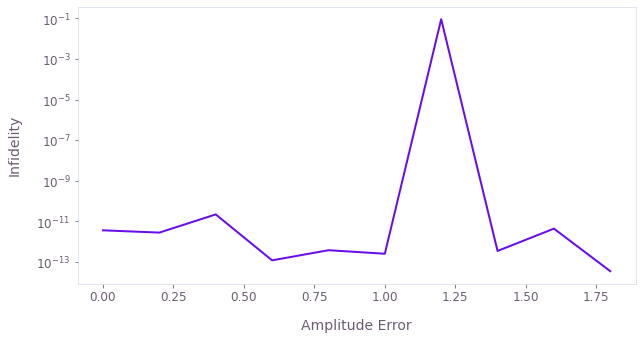

In [122]:
plt.plot(amplitude_error_values, infidelity_scan)
plt.xlabel('Amplitude Error')
plt.ylabel('Infidelity')
plt.yscale('log')

### Adding Detuning Error to model directly (constant offset, same as above)

In [126]:
omega_max = 5 * 2 * np.pi * 1e6 # rad/s
delta_max = omega_max
tau = 0.4 * 1e-6 # s
def optimize_LP_gate(omega_max = 5 * 2 * np.pi * 1e6 , delta_max = omega_max, tau = 0.4 * 1e-6, segment_count =2 , detuning_error_values = 0):
    graph = bo.Graph()
    sample_times = np.linspace(0, tau, 200)
    # Real piece-wise constant signal representing the detuning.
    delta = (
        graph.real_optimizable_pwc_signal(
            segment_count = 1, 
            duration = tau, 
            minimum = 0,
            maximum = delta_max,
            name = 'delta'
        )
    )

    # Real piece-wise constant signal representing the Rabi amplitude.
    omega = (
        graph.real_optimizable_pwc_signal(
            segment_count = 1, 
            duration = tau, 
            minimum = 0,
            maximum = omega_max,
            name = 'omega'
        )
    )

    # Real piece-wise constant signal representing the Rabi phase.
    phi = (
        graph.real_optimizable_pwc_signal(
            segment_count = segment_count, 
            duration = tau, 
            minimum = 0,
            maximum = 2 * np.pi, 
            name = 'phi'
        )
    )

    # Real scalar signal representing the single qubit phase.
    psi = (
        graph.optimizable_scalar(
            lower_bound = 0,
            upper_bound = 2 * np.pi, 
            name = 'psi'
        )
    )
    # if amplitude_error == True:
    #     scan_point_count = 0.01
    #     amplitude_error_values = np.arange(0,0.10,scan_point_count)
    #     amp_noise_signals = []
    #     for i in range(len(amplitude_error_values)):
    #         amp_noise_signals.append(
    #             graph.constant_pwc(
    #                 constant=amplitude_error_values[i][None, :, None],
    #                 duration=tau,
    #                 batch_dimension_count= 2))
    #amp_error == True:
    detuning_error = graph.constant_pwc(
        constant=detuning_error_values,
        duration=tau,

        )
    #add amplitude noise to the hamiltonian
    hamiltonian = (
        graph.hermitian_part(
            (omega * graph.exp(1j * phi) * drive_operator) 
            + (delta+detuning_error) * detuning_operator
        )
    )
    # if detune_error == True:
    #     detuning_error = graph.constant_pwc(
    #         constant=detuning_error_values,
    #         duration=tau,

    #     )
    #     hamiltonian = (
    #         graph.hermitian_part(
    #             (omega * graph.exp(1j * phi) * drive_operator) 
    #             + (delta+detuning_error) * detuning_operator
    #         )
    #     )
    # else:
    #     hamiltonian = (
    #         graph.hermitian_part(
    #             (omega * graph.exp(1j * phi) * drive_operator) 
    #             + delta * detuning_operator
    #         )
    #     )

        # Define the target operator.    
    # Define the Hamiltonian.
    # hamiltonian = (
    # graph.hermitian_part(omega * graph.exp(1j * phi) * drive_operator) + 
    # delta * detuning_operator
    # )

        # Define the target operator.
    target = (
        graph.target(
            operator = (
                cz_0 +
                graph.exp(1j * psi) * cz_1 + 
                graph.exp(1j * (2 * psi + np.pi)) * cz_11
            )
        )
    )

    # Unitary time evolution.
    unitary = (
        graph.time_evolution_operators_pwc(
            hamiltonian = hamiltonian, 
            sample_times = sample_times, 
            name = 'unitary'
        )
    )

    # Infidelity.
    infidelity = (
        graph.infidelity_pwc(
            hamiltonian = hamiltonian,
            target = target,
            name = 'infidelity'
        )
    )

    # Cost function.
    cost_function = (
        graph.sum(
            infidelity
        )
    )
    cost_function.name = 'cost_function'
    
    result = (
    bo.run_optimization(
        graph = graph,
        cost_node_name = 'cost_function',
        output_node_names = [
            'omega', 
            'delta', 
            'phi', 
            'psi', 
            'unitary',
            'infidelity'
        ],
    )
)
    return result

In [127]:
# scan through increasing values of amplitude error and calculate infidelity
scan_point_count = 0.03
detuning_error_values = np.arange(0,0.3,scan_point_count)
infidelity_scan = []
for error_val_detune in range(len(detuning_error_values)):    
    result = optimize_LP_gate(omega_max, delta_max, tau, segment_count,error_val_detune)
    infidelity_scan.append(result['output']['infidelity']['value'])
    print("Gate infidelity is", f"{result['output']['infidelity']['value']:.3e}")

Your task (action_id="1989513") has started.
Your task (action_id="1989513") has completed.
Gate infidelity is 7.550e-14
Your task (action_id="1989514") has started.
Your task (action_id="1989514") has completed.
Gate infidelity is 3.656e-11
Your task (action_id="1989515") is queued.
Your task (action_id="1989515") has completed.
Gate infidelity is 1.615e-01
Your task (action_id="1989516") is queued.
Your task (action_id="1989516") has completed.
Gate infidelity is 5.826e-13
Your task (action_id="1989517") has started.
Your task (action_id="1989517") has completed.
Gate infidelity is 1.818e-12
Your task (action_id="1989518") has started.
Your task (action_id="1989518") has completed.
Gate infidelity is 1.334e-12
Your task (action_id="1989519") has started.
Your task (action_id="1989519") has completed.
Gate infidelity is 2.887e-15
Your task (action_id="1989520") has started.
Your task (action_id="1989520") has completed.
Gate infidelity is 3.699e-13
Your task (action_id="1989521") has 

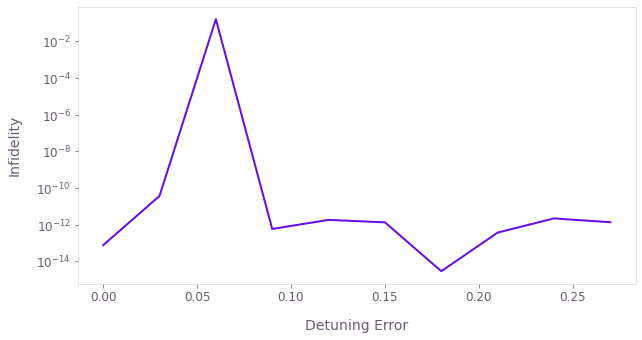

In [128]:
plt.plot(detuning_error_values, infidelity_scan)
plt.xlabel('Detuning Error')
plt.ylabel('Infidelity')
plt.yscale('log')